# Feature Engineer

In [62]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from matplotlib.ticker import StrMethodFormatter
from sklearn.preprocessing import MinMaxScaler


from collections import namedtuple, defaultdict

In [63]:
zip = zipfile.ZipFile('../data/archive.zip')
fp = zip.open('Historical Product Demand.csv') 
df = pd.read_csv(fp)


df.dropna(subset=['Date'], inplace=True)
df.dropna(subset=['Order_Demand'], inplace=True)

df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")
df['Order_Demand'] = df['Order_Demand'].astype('int64')

df['Date'] = pd.to_datetime(df['Date']) 
df.sort_values('Date', inplace=True)

df['Month']  = df['Date'].dt.month_name()
df['Year']   = df['Date'].dt.year
df['Months'] = df['Date'].dt.to_period('M').dt.to_timestamp()

/tmp/ipykernel_6152/1904672436.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
/tmp/ipykernel_6152/1904672436.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")


In [64]:
df_whse_a = df[df.Warehouse == 'Whse_A']

In [65]:
n_products = len(set(df_whse_a['Product_Code']))
n_rows = len(df_whse_a)
n_warehouse = len(set(df_whse_a['Warehouse']))
n_categories = len(set(df_whse_a['Product_Category']))

print(f"""
#rows:       {n_rows}
#products:   {n_products}
#categories: {n_categories}
#warehouse:  {n_warehouse}
""")


#rows:       142335
#products:   427
#categories: 25
#warehouse:  1



In [66]:
x = df_whse_a[(df_whse_a.Months >= '2012-01-01') & (df_whse_a.Months < '2017-01-01')].groupby('Months')['Order_Demand'].sum()
x = x.reset_index()

In [67]:
# choose a warehouse
df_whse_a.drop(['Warehouse', 'Product_Category'], axis=1, inplace=True)

/tmp/ipykernel_6152/3432016049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_whse_a.drop(['Warehouse', 'Product_Category'], axis=1, inplace=True)


In [68]:
# filter for freuent product
threshold = 1000
filtered_data = df_whse_a[(df_whse_a.Year >= 2012) & (df_whse_a.Year < 2017)]
frequent_products = filtered_data['Product_Code'].value_counts()[filtered_data['Product_Code'].value_counts() > threshold].index
filtered_data = filtered_data[filtered_data.Product_Code.isin(frequent_products)]

In [69]:
# aggregation
data_aggregated       = filtered_data[['Product_Code', 'Date', 'Order_Demand']]
data_aggregated       = data_aggregated.groupby(['Product_Code', 'Date']).sum().reset_index()

# weekly
data_pivot            = data_aggregated.pivot(index='Date', columns='Product_Code', values='Order_Demand').fillna(0)
data_resampled_weekly = data_pivot.resample('W').sum()

# daily
daily_index           = pd.date_range(start=data_resampled_weekly.index.min(), end=data_resampled_weekly.index.max(), freq='D')
data_resampled_daily  = data_resampled_weekly.reindex(daily_index).ffill() / 7

In [70]:
import numpy as np
from numpy.fft import fft

def spectrogram(audio, win = 7, step=1, normalize=True):
    spectrogram = []
    hanning = np.hanning(win)
    for i in range(win, len(audio), step):
        dft = np.abs(fft(audio[i - win: i] * hanning))
        if normalize:
            mu  = np.mean(dft)
            std = np.std(dft) + 1.0
            spectrogram.append((dft - mu) / std)
        else:
            spectrogram.append(dft)        
    spectrogram = np.array(spectrogram)[:, :win//2]
    return spectrogram


In [71]:
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

WEEK_IDX = {
  'Monday' : 0,
  'Tuesday': 1,
  'Wednesday': 2,
  'Thursday': 3,
  'Friday':4 ,
  'Saturday': 5,
  'Sunday': 6, 
}
def days_of_week(df, time_steps=1): 
    names = list(df.index.day_name())
    names = [WEEK_IDX[name] for name in names]
    X = []
    for i in range(len(names) - time_steps):
        X.append(names[i:(i + time_steps)])
    return np.array(X)


MONTH_IDX = {
    'January': 0,
    'February': 1,
    'March': 2,
    'April': 3,
    'May': 4,
    'June': 5,
    'July': 6,
    'August': 7,
    'September': 8,
    'October': 9,
    'November': 10,
    'December': 11
}
def month_of_year(df, time_steps=1): 
    names = list(df.index.month_name())
    names = [MONTH_IDX[name] for name in names]
    X = []
    for i in range(len(names) - time_steps):
        X.append(names[i:(i + time_steps)])
    return np.array(X)


def spectrogram_features(data, time_steps=1):
    t, d = data.shape
    spectrograms = []
    for i in range(0, d):
        spectrograms.append(spectrogram(data[:, i], win=30).T)
    stacked = np.stack(spectrograms).T
    X = []
    for i in range(len(stacked) - time_steps):
        X.append(stacked[i:(i + time_steps)])
    return np.array(X)

In [72]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_resampled_daily)

In [73]:
spec = spectrogram_features(scaled_data, time_steps=30)

In [74]:
month_features = month_of_year(data_resampled_daily, time_steps=30)

In [75]:
day_features = days_of_week(data_resampled_daily, time_steps=30)

In [76]:
time_steps = 30  # e.g., 30 days
X, y = create_sequences(scaled_data, time_steps)

In [77]:
X.shape, y.shape, month_features.shape, day_features.shape, spec.shape

((1791, 30, 31), (1791, 31), (1791, 30), (1791, 30), (1761, 30, 15, 31))

In [78]:
import pickle as pkl

Features = namedtuple('Features', 'seq month day spec lab')

with open('features.pkl', 'wb') as f:
    pkl.dump(Features(X, month_features, day_features, spec, y), f)

# Modeling

In [30]:
import pickle as pkl
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import * 
from tensorflow.keras.models import * 
from collections import namedtuple
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import * 
from tensorflow.keras.metrics import * 
Features = namedtuple('Features', 'seq month day spec lab')

In [31]:
features = pkl.load(open('features.pkl', 'rb'))
X_train, X_test, y_train, y_test = train_test_split(features.seq, features.lab, test_size=0.3)

## Base Model

In [32]:
print(X_train.shape, y_train.shape)

(1253, 30, 31) (1253, 31)


In [33]:
def predictor():
    i = Input((30, 31))
    x = LSTM(31, activation='relu')(i)
    return Model(inputs=[i], outputs=[x])

model = predictor()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 30, 31)]          0         
                                                                 
 lstm_3 (LSTM)               (None, 31)                7812      
                                                                 
Total params: 7,812
Trainable params: 7,812
Non-trainable params: 0
_________________________________________________________________


In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
opt = Adam(learning_rate=0.02)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[RootMeanSquaredError()])
hist = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
40/40 [==============================] - 5s 76ms/step - loss: 0.0306 - root_mean_squared_error: 0.1748 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1515
Epoch 2/50
40/40 [==============================] - 3s 69ms/step - loss: 0.0211 - root_mean_squared_error: 0.1453 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1409
Epoch 3/50
40/40 [==============================] - 3s 68ms/step - loss: 0.0190 - root_mean_squared_error: 0.1380 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1364
Epoch 4/50
40/40 [==============================] - 3s 75ms/step - loss: 0.0181 - root_mean_squared_error: 0.1345 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1333
Epoch 5/50
40/40 [==============================] - 3s 80ms/step - loss: 0.0176 - root_mean_squared_error: 0.1326 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1322
Epoch 6/50
40/40 [==============================] - 3s 75ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0173 - val_root_m

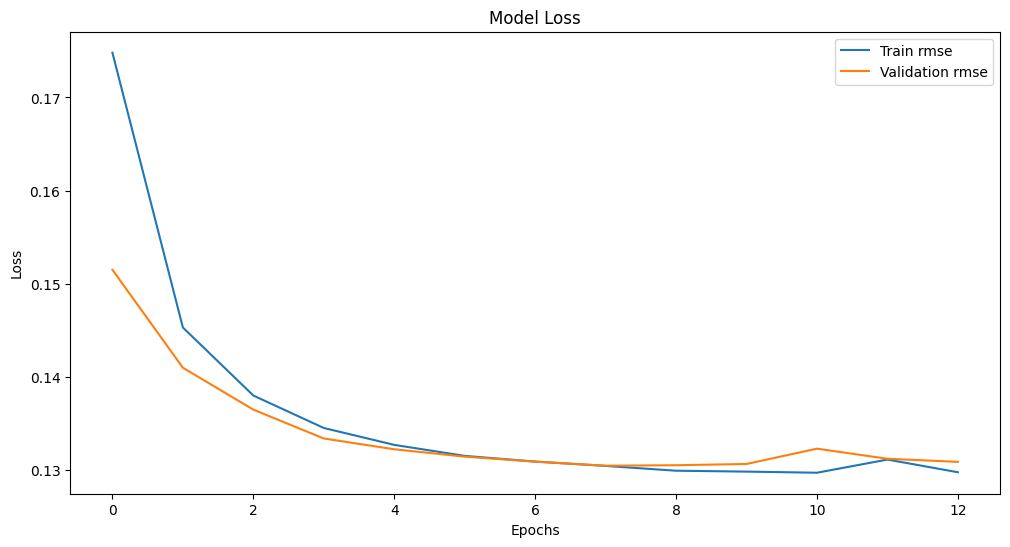

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['root_mean_squared_error'], label='Train rmse')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation rmse')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [36]:
features.day.shape, features.month.shape

((1791, 30), (1791, 30))

## Include Day of Week / Month of Year

### Learned Embedding

In [37]:
def predictor_v2():
    i_seq = Input((30, 31))
    i_month = Input((30))
    i_day = Input((30))
    
    e_month = Embedding(12, 12)(i_month)
    e_day = Embedding(7, 7)(i_day) 
    
    i = Concatenate(axis = 2)([i_seq, e_month, e_day])
    
    
    x = LSTM(31, activation='relu')(i)
    return Model(inputs=[i_seq, i_day, i_month], outputs=[x])

model = predictor_v2()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 30, 31)]     0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 12)       144         ['input_27[0][0]']               
                                                                                            

In [38]:
X_train, X_test, y_train, y_test, day_train, day_test, month_train, month_test =\
train_test_split(features.seq, features.lab, features.day, features.month, test_size=0.3)

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
opt = Adam(learning_rate=0.02)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[RootMeanSquaredError()])
hist = model.fit([X_train, day_train, month_train], y_train, batch_size=32, epochs=50, validation_data=([X_test, day_test, month_test], y_test), callbacks=[early_stopping])

Epoch 1/50
40/40 [==============================] - 5s 84ms/step - loss: 0.0311 - root_mean_squared_error: 0.1765 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1570
Epoch 2/50
40/40 [==============================] - 3s 70ms/step - loss: 0.0210 - root_mean_squared_error: 0.1448 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1406
Epoch 3/50
40/40 [==============================] - 3s 69ms/step - loss: 0.0179 - root_mean_squared_error: 0.1339 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1335
Epoch 4/50
40/40 [==============================] - 3s 74ms/step - loss: 0.0167 - root_mean_squared_error: 0.1293 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1288
Epoch 5/50
40/40 [==============================] - 3s 72ms/step - loss: 0.0158 - root_mean_squared_error: 0.1256 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1252
Epoch 6/50
40/40 [==============================] - 3s 75ms/step - loss: 0.0153 - root_mean_squared_error: 0.1237 - val_loss: 0.0153 - val_root_m

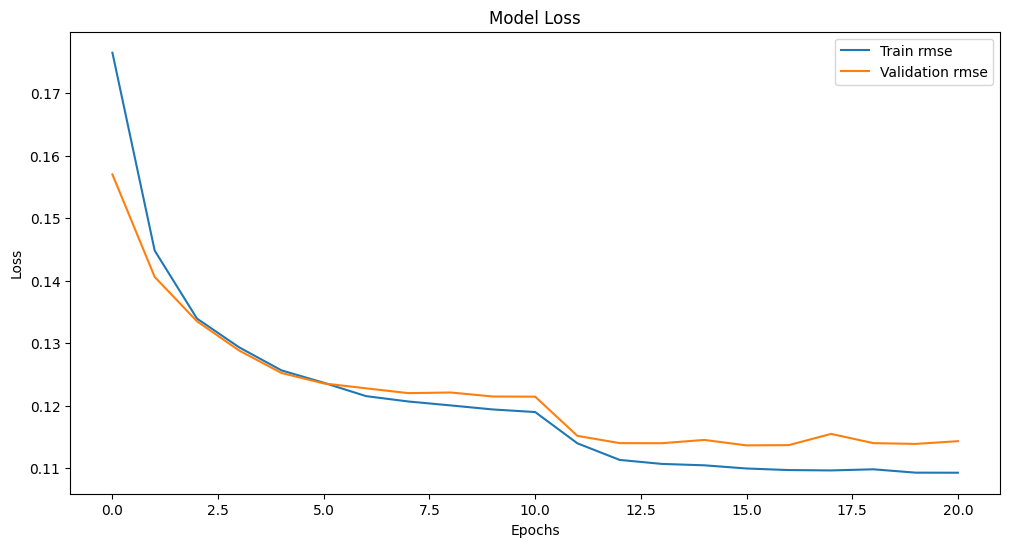

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['root_mean_squared_error'], label='Train rmse')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation rmse')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### LSTM Stack

In [41]:
def predictor_v2_2():
    i_seq = Input((30, 31))
    i_month = Input((30))
    i_day = Input((30))
    
    e_month = Embedding(12, 12)(i_month)
    e_day = Embedding(7, 7)(i_day) 
    
    i = Concatenate(axis = 2)([i_seq, e_month, e_day])
    
    
    x = Bidirectional(LSTM(128, return_sequences=True))(i)
    x = LSTM(31, activation='relu')(x)
    return Model(inputs=[i_seq, i_day, i_month], outputs=[x])


model = predictor_v2_2()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 input_29 (InputLayer)          [(None, 30, 31)]     0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 30, 12)       144         ['input_30[0][0]']               
                                                                                            

In [42]:
X_train, X_test, y_train, y_test, day_train, day_test, month_train, month_test =\
train_test_split(features.seq, features.lab, features.day, features.month, test_size=0.3)

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
opt = Adam(learning_rate=0.02)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[RootMeanSquaredError()])
hist = model.fit([X_train, day_train, month_train], y_train, batch_size=32, epochs=50, validation_data=([X_test, day_test, month_test], y_test), callbacks=[early_stopping])

Epoch 1/50
40/40 [==============================] - 12s 124ms/step - loss: 81374056.0000 - root_mean_squared_error: 9020.7568 - val_loss: 8.0828 - val_root_mean_squared_error: 2.8430
Epoch 2/50
40/40 [==============================] - 3s 83ms/step - loss: 8.2291 - root_mean_squared_error: 2.8686 - val_loss: 0.2520 - val_root_mean_squared_error: 0.5020
Epoch 3/50
40/40 [==============================] - 3s 83ms/step - loss: 0.2659 - root_mean_squared_error: 0.5157 - val_loss: 0.2460 - val_root_mean_squared_error: 0.4960
Epoch 4/50
40/40 [==============================] - 3s 84ms/step - loss: 0.2575 - root_mean_squared_error: 0.5075 - val_loss: 0.2437 - val_root_mean_squared_error: 0.4937
Epoch 5/50
40/40 [==============================] - 3s 82ms/step - loss: 0.2550 - root_mean_squared_error: 0.5050 - val_loss: 0.2413 - val_root_mean_squared_error: 0.4912
Epoch 6/50
40/40 [==============================] - 3s 83ms/step - loss: 0.2524 - root_mean_squared_error: 0.5024 - val_loss: 0.2387 

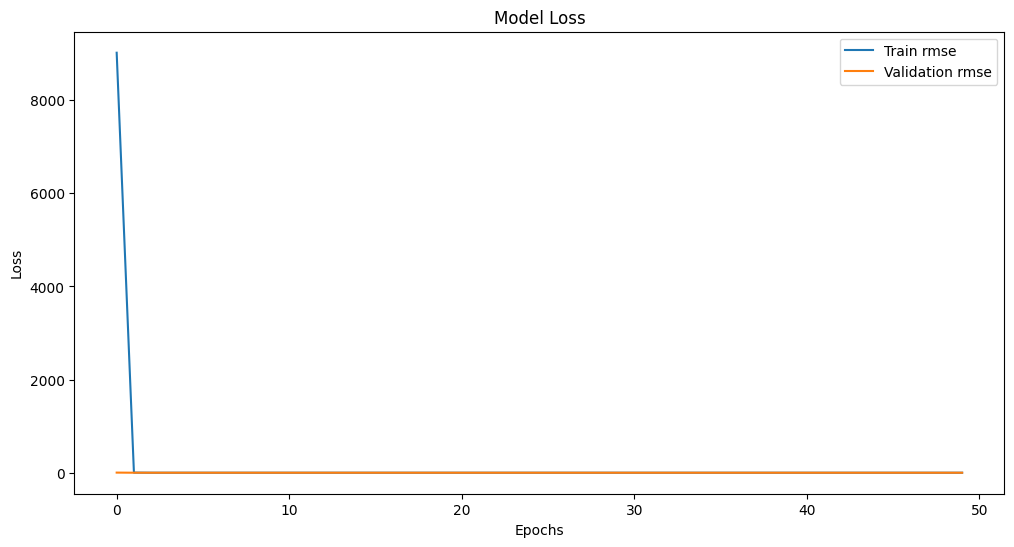

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['root_mean_squared_error'], label='Train rmse')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation rmse')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Encoding

In [48]:
def predictor_v2_3():
    i_seq = Input((30, 31))
    i_month = Input((30, 1))
    i_day = Input((30, 1))
    
    e_month = TimeDistributed(CategoryEncoding(num_tokens=12))(i_month)
    e_day = TimeDistributed(CategoryEncoding(num_tokens=7))(i_day) 
    print(e_month.shape)
    i = Concatenate(axis = 2)([i_seq, e_month, e_day])
    
    x = LSTM(31, activation='relu')(i)
    return Model(inputs=[i_seq, i_day, i_month], outputs=[x])


model = predictor_v2_3()
model.summary()

(None, 30, 12)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 30, 1)]      0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None, 30, 1)]      0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 30, 31)]     0           []                               
                                                                                                  
 time_distributed_5 (TimeDistri  (None, 30, 12)      0           ['input_33[0][0]']               
 buted)                                                                      

In [49]:
X_train, X_test, y_train, y_test, day_train, day_test, month_train, month_test =\
train_test_split(features.seq, features.lab, features.day, features.month, test_size=0.3)

In [50]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
opt = Adam(learning_rate=0.02)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[RootMeanSquaredError()])
hist = model.fit([X_train, day_train, month_train], y_train, batch_size=32, epochs=50, validation_data=([X_test, day_test, month_test], y_test), callbacks=[early_stopping])

Epoch 1/50
40/40 [==============================] - 5s 73ms/step - loss: 0.0543 - root_mean_squared_error: 0.2329 - val_loss: 0.0498 - val_root_mean_squared_error: 0.2232
Epoch 2/50
40/40 [==============================] - 2s 62ms/step - loss: 0.0466 - root_mean_squared_error: 0.2159 - val_loss: 0.0492 - val_root_mean_squared_error: 0.2219
Epoch 3/50
40/40 [==============================] - 2s 62ms/step - loss: 0.0462 - root_mean_squared_error: 0.2150 - val_loss: 0.0488 - val_root_mean_squared_error: 0.2208
Epoch 4/50
40/40 [==============================] - 3s 62ms/step - loss: 0.0458 - root_mean_squared_error: 0.2140 - val_loss: 0.0486 - val_root_mean_squared_error: 0.2204
Epoch 5/50
40/40 [==============================] - 2s 58ms/step - loss: 0.0456 - root_mean_squared_error: 0.2136 - val_loss: 0.0484 - val_root_mean_squared_error: 0.2200
Epoch 6/50
40/40 [==============================] - 2s 60ms/step - loss: 0.0455 - root_mean_squared_error: 0.2133 - val_loss: 0.0483 - val_root_m

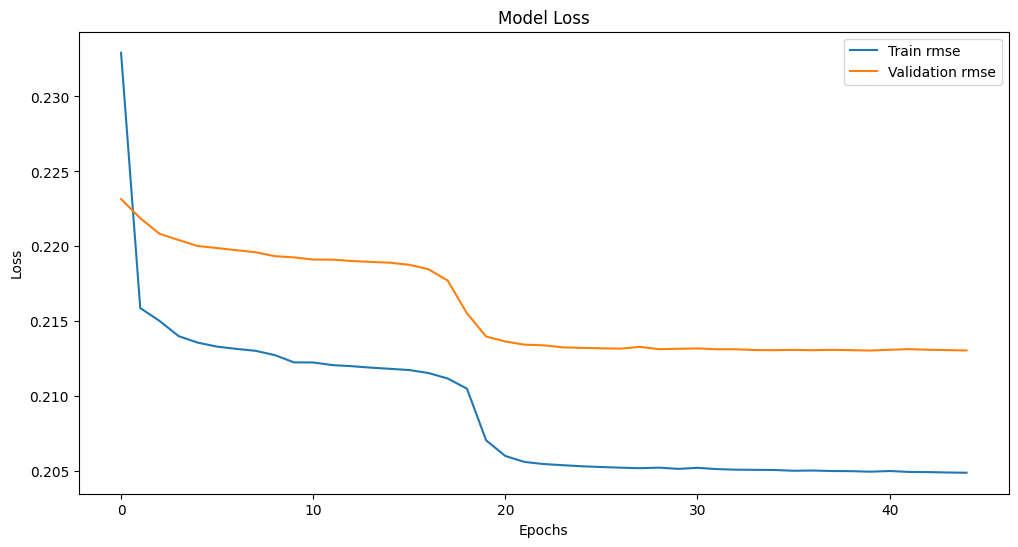

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['root_mean_squared_error'], label='Train rmse')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation rmse')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Spectogram Features

In [52]:
features.spec.shape

(1761, 30, 15, 31)

In [53]:
def predictor_v3():
    i_seq = Input((30, 31))
    i_month = Input((30))
    i_day = Input((30))
    i_spec = Input((30, 15, 31))
    
    c_spec = BatchNormalization()(i_spec)
    c_spec = Convolution2D(128, kernel_size=(7, 15), padding='same')(c_spec)
    c_spec = MaxPool2D((1, 15))(c_spec)
    c_spec = Reshape((30, 128))(c_spec)
    
    e_month = Embedding(12, 12)(i_month)
    e_day = Embedding(7, 7)(i_day) 
    
    i = Concatenate(axis = 2)([i_seq, e_month, e_day, c_spec])
    
    
    x = LSTM(31, activation='relu')(i)
    return Model(inputs=[i_seq, i_day, i_month, i_spec], outputs=[x])

model = predictor_v3()
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 30, 15, 31)  0           []                               
                                ]                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 30, 15, 31)  124         ['input_38[0][0]']               
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 30, 15, 128)  416768      ['batch_normalization[0][0]']    
                                                                                            

In [54]:
n = features.spec.shape[0]

In [55]:
X_train, X_test, y_train, y_test, day_train, day_test, month_train, month_test, spec_train, spec_test =\
train_test_split(features.seq[:n], features.lab[:n], features.day[:n], features.month[:n], features.spec, test_size=0.3)

In [56]:
X_train.shape, month_train.shape, day_train.shape, spec_train.shape

((1232, 30, 31), (1232, 30), (1232, 30), (1232, 30, 15, 31))

In [57]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
opt = Adam(learning_rate=0.02)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[RootMeanSquaredError()])
hist = model.fit([X_train, day_train, month_train, spec_train], y_train, batch_size=32, epochs=50, validation_data=([X_test, day_test, month_test, spec_test], y_test), callbacks=[early_stopping])

Epoch 1/50
39/39 [==============================] - 9s 101ms/step - loss: 13502785.0000 - root_mean_squared_error: 3674.6135 - val_loss: 1257408.5000 - val_root_mean_squared_error: 1121.3422
Epoch 2/50
39/39 [==============================] - 3s 77ms/step - loss: 3327915.7500 - root_mean_squared_error: 1824.2577 - val_loss: 601215.3750 - val_root_mean_squared_error: 775.3808
Epoch 3/50
39/39 [==============================] - 3s 77ms/step - loss: 1513358.8750 - root_mean_squared_error: 1230.1865 - val_loss: 437548.5938 - val_root_mean_squared_error: 661.4745
Epoch 4/50
39/39 [==============================] - 3s 83ms/step - loss: 936744.4375 - root_mean_squared_error: 967.8557 - val_loss: 361335.2500 - val_root_mean_squared_error: 601.1116
Epoch 5/50
39/39 [==============================] - 3s 76ms/step - loss: 661841.5625 - root_mean_squared_error: 813.5364 - val_loss: 311289.2500 - val_root_mean_squared_error: 557.9330
Epoch 6/50
39/39 [==============================] - 3s 76ms/step 

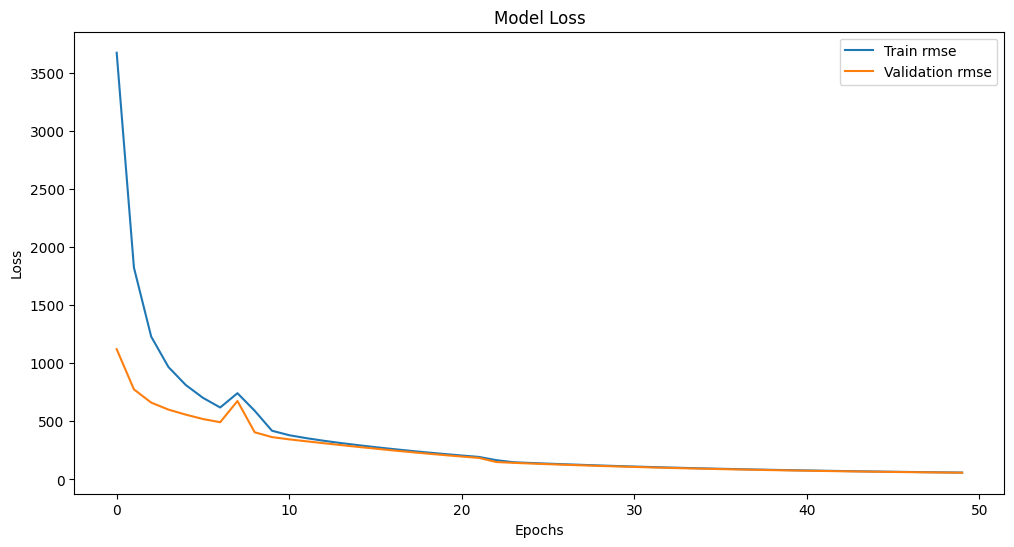

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['root_mean_squared_error'], label='Train rmse')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation rmse')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Inference

In [60]:
def forecast_next_days(model, last_data, days=40):
    predictions = []
    current_data = last_data
    for _ in range(days):
        next_pred = model.predict(current_data.reshape(1, time_steps, current_data.shape[1]))
        predictions.append(next_pred[0])
        current_data = np.append(current_data[1:], [next_pred[0]], axis=0)  # Update the input for the next prediction
    return np.array(predictions)